In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
import os
from datetime import datetime
import random
import string
import multiprocessing as mp
import itertools

In [2]:
import matplotlib.pyplot as plt
import timeit
%load_ext memory_profiler


In [3]:
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [4]:
REWARD = 100

In [5]:
seed = 741
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)

env = gym.make('CartPole-v0')
XTRA_FEAT   = 1 #pole length
N_ACTIONS   = env.action_space.n
N_STATES    = env.observation_space.shape[0]  +  XTRA_FEAT 
ENV_A_SHAPE = 0 if isinstance(env.action_space.sample(), int) else env.action_space.sample().shape     # to confirm the shape

In [6]:
RNDM_STRING = ''.join(random.choices(string.ascii_uppercase + string.digits, k=8)) + datetime.now().strftime("_%H_%M_%S")
print("ID: ",RNDM_STRING)
MODEL_FILENAME = './models/'+ RNDM_STRING + "_NN" + ".pt"
print("NN-MODEL FILENAME: ", MODEL_FILENAME)

ID:  HS78Q8CD_02_13_40
NN-MODEL FILENAME:  ./models/HS78Q8CD_02_13_40_NN.pt


In [7]:
def ndim_grid(start,stop, granularity):
    # Set number of dimensions
    ndims = len(start)

    # List of ranges across all dimensions
    L = [np.linspace(start[i],stop[i],granularity[i]) for i in range(ndims)]

    # Finally use meshgrid to form all combinations corresponding to all 
    # dimensions and stack them as M x ndims array
    return np.hstack((np.meshgrid(*L))).swapaxes(0,1).reshape(ndims,-1).T

In [8]:
def discretize(value, borders):
    c_pos_val, c_vel_val, p_ang_val, p_vel_val, length_val   = value
    c_pos_s  , c_vel_s  ,p_ang_s   , p_vel_s  , length_s     = borders
    
    indx = np.empty_like(value).astype(np.uint)
    
    for i in range(value.shape[0]):
        if value[i] > borders[i].max():
            indx[i] = borders[i].argmax()
        else:
            indx[i] = np.where(borders[i] >= value[i])[0][0].astype(np.uint)
    return indx



In [9]:
T_LR           = 1e-2
T_GAMMA        = 0.99
T_EPSILON      = 0.98

NO_OF_NODES    = 10
NO_OF_EPISODES = 100
TIMESTEP_LIMIT = 200

print("Number of NODES: ", NO_OF_NODES)
print("Number of EPISODES per NODE", NO_OF_EPISODES)

Number of NODES:  10
Number of EPISODES per NODE 100


In [10]:
# Hyper Parameters
HIDDEN_LAYER        = 50
BATCH_SIZE          = 32
NN_LR               = 1e-3  # learning rate
NN_GAMMA            = 0.9   # reward discount
TARGET_REPLACE_ITER = 500   # target update frequency
MIN_MEMORY_CAP      = 200000

In [11]:
MAX_NO_OF_ITERATIONS = 50
MAX_NN_ITERATIONS    = 50000
print("Number of ITERATIONS: ",MAX_NO_OF_ITERATIONS)

Number of ITERATIONS:  50


In [12]:
# class Net(nn.Module):
#     def __init__(self, ):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(N_STATES, 50)
#         nn.init.kaiming_uniform_(self.fc1.weight)   # initialization
#         self.out = nn.Linear(50, N_ACTIONS)
#         nn.init.xavier_uniform_(self.out.weight)   # initialization

#     def forward(self, x):
#         x = self.fc1(x)
#         x = F.relu(x)
#         actions_value = self.out(x)
#         return actions_value

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(N_STATES, HIDDEN_LAYER)
        nn.init.kaiming_uniform_(self.fc1.weight)

        self.adv = nn.Linear(HIDDEN_LAYER, N_ACTIONS)
        nn.init.xavier_uniform_(self.adv.weight) 
    
        self.val = nn.Linear(HIDDEN_LAYER, 1)
        nn.init.xavier_uniform_(self.val.weight)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        adv = self.adv(x)
        val = self.val(x)
        
        return val + adv - adv.mean()
    
class D3QN(object):
    def __init__(self):
        self.eval_net, self.target_net = Net(), Net()

        self.learn_step_counter  = 0 # for target updating
        
        self.memory_counter      = 0
        self.memory              = np.zeros((int(MIN_MEMORY_CAP), N_STATES * 2 + 2)) # initialize memory
        
#         self.good_memory_counter = 0 # for storing non-terminal memories
#         self.good_memory         = np.zeros((MIN_MEMORY_CAP ,N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        
#         self.bad_memory_counter  = 0 # for storing terminal memories
#         self.bad_memory          = np.zeros((MIN_MEMORY_CAP , N_STATES*2+2))#np.zeros((int(MEMORY_CAPACITY/2), N_STATES * 2 + 2)) # initialize memory
        self.running_loss        = 0
        self.optimizer           = torch.optim.Adam(self.eval_net.parameters(), lr=NN_LR)
        self.loss_func           = nn.MSELoss()

    def choose_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        if np.random.uniform() < EPSILON:   # greedy
            actions_value = self.eval_net.forward(x)
            action = torch.max(actions_value, 1)[1].data.numpy()
            action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        else:   # random
            action = np.random.randint(0, N_ACTIONS)
            action = action if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)
        return action
    
    def choose_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions_value = self.eval_net.forward(x)
        action = torch.max(actions_value, 1)[1].data.numpy()
        action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return action
    
    def get_greedy_action(self, x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        # input only one sample
        actions = self.eval_net.forward(x).view(-1,N_ACTIONS).max(1)[1].data.numpy().astype(np.intp)
#         actions_value 
#         action = torch.max(actions_value, 1)[1].data.numpy()
#         action = action[0] if ENV_A_SHAPE == 0 else action.reshape(ENV_A_SHAPE)  # return the argmax index
        return actions
    
    def get_qvals(self,x):
        x = torch.unsqueeze(torch.FloatTensor(x), 0)
        actions_value = self.eval_net.forward(x)
        actions_value = actions_value.data.numpy().astype(np.float16)
        return actions_value

    def learn(self):
        # target parameter update
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            self.target_net.load_state_dict(self.eval_net.state_dict())
        self.learn_step_counter += 1
        
        sample_index_limit = min(MIN_MEMORY_CAP, self.memory_counter)
        sample_index = np.random.choice(int(sample_index_limit),int(BATCH_SIZE))
        b_memory = self.memory[sample_index,:]
#         # sample batch transitions
#         good_sample_index_limit = min(MIN_MEMORY_CAP, self.good_memory_counter)
#         bad_sample_index_limit = min(MIN_MEMORY_CAP, self.bad_memory_counter)

#         good_sample_index = np.random.choice(int(good_sample_index_limit), int(BATCH_SIZE-int(BATCH_SIZE*TERMINAL_BIAS)))
#         bad_sample_index  = np.random.choice(int(bad_sample_index_limit),  int(BATCH_SIZE*TERMINAL_BIAS))

#         b_good_memory = self.good_memory[good_sample_index, :]
#         b_bad_memory  = self.bad_memory[bad_sample_index, :]
#         b_memory      = np.vstack((b_good_memory,b_bad_memory))
        
        b_s  = torch.FloatTensor(b_memory[:, :N_STATES])
        b_a  = torch.LongTensor( b_memory[:, N_STATES:N_STATES+1].astype(int))
        b_r  = torch.FloatTensor(b_memory[:, N_STATES+1:N_STATES+2])
        b_s_ = torch.FloatTensor(b_memory[:, -N_STATES:])

        # q_eval w.r.t the action in experience
        q_eval   = self.eval_net(b_s).gather(1, b_a)  # shape (batch, 1)
        a_eval   = self.eval_net(b_s).max(1)[1].view(BATCH_SIZE, 1) #best action according to eval_net
        q_next   = self.target_net(b_s_).detach()     # detach from graph, don't backpropagate
        q_target = b_r + NN_GAMMA * q_next.gather(1, a_eval)   # shape (batch, 1)
        loss     = self.loss_func(q_eval, q_target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.running_loss += loss.mean().item()
        if self.learn_step_counter % TARGET_REPLACE_ITER == 0:
            print('LOSS : %.3f' %(self.running_loss / TARGET_REPLACE_ITER), end="\t")
            self.running_loss = 0.0

In [13]:
def clamp(MIN_VAL, VAL, MAX_VAL):
    return max(MIN_VAL, min(VAL, MAX_VAL))

In [14]:
# ABSOLUTE LIMITS ON STATE VALUES
C_POS_ABS_MAX =  2.6
C_POS_ABS_MIN = -2.6

C_VEL_ABS_MAX =  5
C_VEL_ABS_MIN = -5

P_ANG_ABS_MAX =  0.25
P_ANG_ABS_MIN = -0.25

P_VEL_ABS_MAX =  6
P_VEL_ABS_MIN = -6

LENGTH_ABS_MAX = 0.725
LENGTH_ABS_MIN = 0.275

In [15]:
# SET GRANULARITY
HI_GRAIN = 40
LO_GRAIN = 1
print("HI_GRAIN = ", HI_GRAIN)
print("LO_GRAIN = ", LO_GRAIN)

HI_GRAIN =  40
LO_GRAIN =  1


In [16]:
def mp_node_run(node_id, boundary, iteration, node_q_table):

    # SET SEED
    ###############################################
    my_seed = seed + node_id + iteration
    random.seed(my_seed)
    torch.manual_seed(my_seed)
    np.random.seed(my_seed)
    os.environ['PYTHONHASHSEED'] = str(my_seed)
    my_env = env
    my_env.seed(my_seed)
    ###############################################
     # Mean values of pole length deviate from original value
    scaling_factor = 0.4 + (1.4 - 0.4) * (node_id + 1)/(NO_OF_NODES)
    ORIGNAL_LENGTH = 0.5    
    length_mean    = ORIGNAL_LENGTH * scaling_factor

    LENGTH_MAX = length_mean + 0.025
    LENGTH_MIN = length_mean - 0.025

    # CREATE STATE TABLE BORDERS
    ###############################################
    c_pos_s  = np.linspace(C_POS_ABS_MIN,  C_POS_ABS_MAX,  HI_GRAIN)
    c_vel_s  = np.linspace(C_VEL_ABS_MIN,  C_VEL_ABS_MAX,  HI_GRAIN)
    p_ang_s  = np.linspace(P_ANG_ABS_MIN,  P_ANG_ABS_MAX,  HI_GRAIN)
    p_vel_s  = np.linspace(P_VEL_ABS_MIN,  P_VEL_ABS_MAX,  HI_GRAIN)
    length_s = np.linspace(LENGTH_MIN,     LENGTH_MAX,     LO_GRAIN)

    borders = [c_pos_s, c_vel_s, p_ang_s, p_vel_s, length_s]
    ###############################################
    
    my_Q_TABLE = node_q_table[:,:,:,:, int(node_id*LO_GRAIN):int((node_id+1)*LO_GRAIN)]

    time_rec                = np.zeros(NO_OF_EPISODES)
    level_up_flag           = False
    PERFECT_RUN_COUNTER     = 10
    PERFECT_RUNS_HIGH_SCORE = 10
    level_up_metric         = 195

    exp_rec      = np.empty(N_STATES * 2 + 2)
    
#     if iteration < 3:
    my_EPSILON   = np.clip(((3%5 + 1)*0.1 + (iteration)*0.2) ,0.4,0.98)+ np.random.uniform(-0.01,0.01)
#     print(node_id, my_EPSILON)
#     else:
#         my_EPSILON   = T_EPSILON + np.random.uniform(-0.01,0.01)
    
    while True:
        i_episode = 0
        
        while i_episode < NO_OF_EPISODES:
            ep_exp_rec = np.empty(N_STATES * 2 + 2)
            time_steps = 0
            
            my_env.length   = length_mean + np.random.uniform(-0.025,0.025)
            xtra = [my_env.length]
            
            s = my_env.reset()
            s = np.append(s, xtra)
            while True:
                time_steps += 1
                
                #get state
                this_state = tuple(discretize(s, borders))
                
                # choose action
                if np.random.uniform() > my_EPSILON:   # greedy
                    a = np.random.randint(0, N_ACTIONS)
                else:
                    a = my_Q_TABLE[this_state]

                 # take action
                s_, r, done, info = my_env.step(a)
                s_ = np.append(s_, xtra)

                if done:
                    r = -REWARD
                    if time_steps >= TIMESTEP_LIMIT:
                        r = REWARD
                
                #store experience
                experience = np.hstack((s,a,r,s_))
                exp_rec = np.vstack((exp_rec, experience))

                #discretize next_state
                next_state = tuple(discretize(s_, borders))
                
                if done or time_steps >= TIMESTEP_LIMIT:
                    time_rec[i_episode] = time_steps
                    break
                s = s_

            i_episode += 1
        if i_episode >= NO_OF_EPISODES:
            i_episode = 0
            break

    exp_rec = np.delete(exp_rec, 0, 0)
#         message = "NODE#"+str(node_id) +" MAIN Q:"+ str(new_Q_TABLE.mean()) +"\t" + "NODE Q:" + str(my_Q_TABLE.mean())
#         print(message)
    
    # GET NEW STATE BOUNDARIES: +/- 25% of experienced state
    [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX ] = [exp_rec[:,i].max() for i in range(N_STATES)]
    [C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN ] = [exp_rec[:,i].min() for i in range(N_STATES)]

    newboundary = [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
                   C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]
    
    return exp_rec, time_rec, newboundary

In [17]:
total_serial_timesteps   = 0
total_parallel_timesteps = 0

In [18]:
iteration = 0
# my_dqn = D3QN()
dqn = D3QN()

# INITIALIZE BOUNDARY TO MAXIMUM VALUES
init_node_boundary = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX,
                      C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN]



# CREATE STATE COMBINATIONS
# ###############################################

init_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
                                    [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
                                    [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN*NO_OF_NODES   ])



# # GET Q-VALUES 
start = timeit.default_timer()
%memit init_q_table = dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN,LO_GRAIN*NO_OF_NODES).astype(np.intp)
stop = timeit.default_timer()
print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    
# SAVE QFILE
# node_QFILE = './Q_NPY/' + RNDM_STRING + 'QFILE' + ".npy"
# np.save(node_QFILE, init_q_table)

peak memory: 12038.02 MiB, increment: 10919.61 MiB
Quantization TIME:  0.11 minutes


In [19]:
# ENVIRONMENT FOR CHECKING NN MODEL
v_env = gym.make('CartPole-v0')
v_env.seed(seed*2)

# CREATE A POOL OF PROCESSES
pool = mp.Pool(NO_OF_NODES)

# SET INITIAL NODE BOUDNARIES FOR ALL NODES
node_boundaries = [init_node_boundary] * NO_OF_NODES
node_q_table = init_q_table



ITERATION # 0
TOTAL EXPERIENCE GENERATED:   15553
SMALLEST TIMESTEP: 8
LARGEST  TIMESTEP: 86
TOTAL SERIAL TIMESTEPS:   15553
TOTAL PARALLEL TIMESTEPS: 86


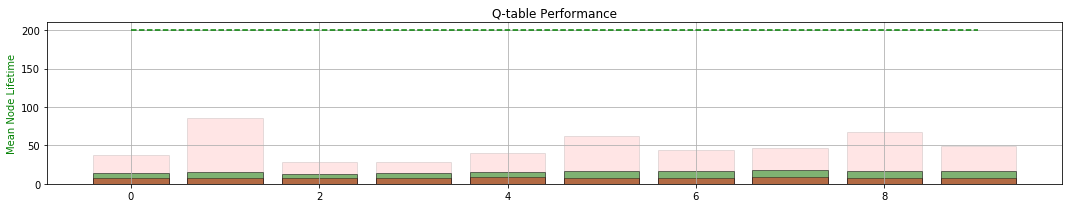

MEMORY COUNTER:  15553
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 579.994	LOSS : 574.136	LOSS : 538.690	LOSS : 524.234	LOSS : 539.393	LOSS : 528.402	LOSS : 542.945	LOSS : 532.651	LOSS : 520.088	LOSS : 509.645	LOSS : 521.158	LOSS : 523.046	LOSS : 504.085	LOSS : 492.369	LOSS : 489.732	LOSS : 491.254	LOSS : 478.014	LOSS : 479.053	LOSS : 469.576	LOSS : 478.604	
Validating... MEAN TIME:  121.08
LOSS : 487.906	LOSS : 487.302	LOSS : 467.372	LOSS : 475.871	LOSS : 457.757	LOSS : 460.251	LOSS : 472.470	LOSS : 467.258	LOSS : 458.282	LOSS : 448.339	LOSS : 455.276	LOSS : 428.117	LOSS : 427.214	LOSS : 450.561	LOSS : 437.040	LOSS : 479.456	LOSS : 435.116	LOSS : 455.207	LOSS : 469.131	LOSS : 446.052	
Validating... MEAN TIME:  140.535
LOSS : 462.370	LOSS : 456.849	LOSS : 445.134	LOSS : 458.661	LOSS : 455.712	LOSS : 464.458	LOSS : 457.517	LOSS : 463.729	LOSS : 464.289	LOSS : 471.450	LOSS : 448.350	LOSS : 468.491	LOSS : 459.898	LOSS : 476.072	LOSS : 471.631	LOSS : 472.377	LOSS : 46

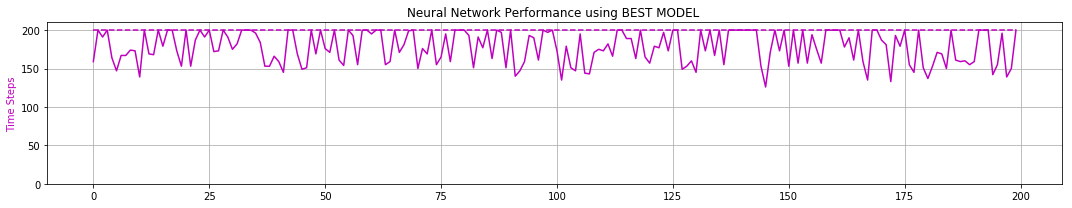

peak memory: 12087.53 MiB, increment: 10737.86 MiB
0 -max- [ 0.176  1.522  0.209  2.691  0.275]
0 -min- [-0.292 -1.793 -0.203 -2.462  0.225]

1 -max- [ 0.229  2.169  0.209  2.758  0.324]
1 -min- [-0.423 -1.884 -0.207 -3.000  0.275]

2 -max- [ 0.194  1.971  0.209  2.674  0.374]
2 -min- [-0.224 -1.724 -0.209 -2.967  0.326]

3 -max- [ 0.215  2.088  0.209  2.468  0.424]
3 -min- [-0.214 -1.597 -0.206 -2.999  0.375]

4 -max- [ 0.228  2.079  0.209  2.214  0.474]
4 -min- [-0.182 -1.374 -0.208 -2.825  0.425]

5 -max- [ 0.942  3.182  0.209  2.423  0.524]
5 -min- [-0.212 -1.585 -0.207 -2.793  0.475]

6 -max- [ 0.245  2.511  0.208  2.107  0.575]
6 -min- [-0.273 -1.546 -0.209 -3.187  0.527]

7 -max- [ 0.460  2.500  0.208  2.418  0.624]
7 -min- [-0.197 -1.565 -0.208 -2.624  0.576]

8 -max- [ 0.871  2.882  0.209  2.215  0.673]
8 -min- [-0.222 -1.336 -0.209 -3.144  0.626]

9 -max- [ 0.656  2.503  0.209  1.650  0.724]
9 -min- [-0.105 -0.973 -0.209 -2.782  0.676]

Quantization TIME:  0.11 minutes


ITER

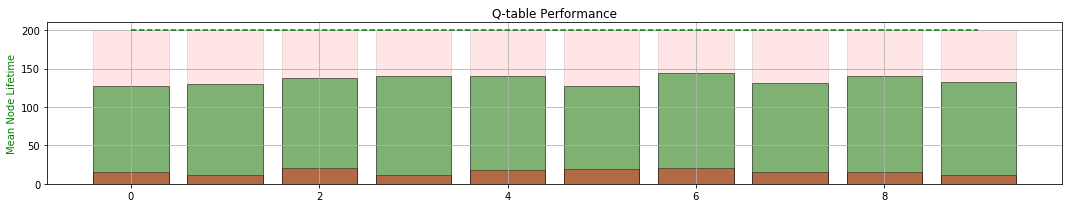

MEMORY COUNTER:  150459
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 285.407	LOSS : 260.949	LOSS : 248.203	LOSS : 232.839	LOSS : 215.738	LOSS : 226.411	LOSS : 209.204	LOSS : 195.968	LOSS : 191.691	LOSS : 187.028	LOSS : 189.673	LOSS : 174.309	LOSS : 173.011	LOSS : 176.732	LOSS : 173.371	LOSS : 165.088	LOSS : 166.210	LOSS : 173.962	LOSS : 160.844	LOSS : 159.338	
Validating... MEAN TIME:  191.485
LOSS : 159.732	LOSS : 164.816	LOSS : 155.562	LOSS : 141.917	LOSS : 140.662	LOSS : 145.760	LOSS : 150.039	LOSS : 145.714	LOSS : 151.292	LOSS : 151.994	LOSS : 145.968	LOSS : 132.674	LOSS : 142.440	LOSS : 142.212	LOSS : 145.294	LOSS : 134.034	LOSS : 148.312	LOSS : 135.210	LOSS : 144.368	LOSS : 142.028	
Validating... MEAN TIME:  193.295
LOSS : 134.451	LOSS : 142.589	LOSS : 144.438	LOSS : 137.227	LOSS : 139.795	LOSS : 137.531	LOSS : 135.315	LOSS : 132.518	LOSS : 138.814	LOSS : 121.276	LOSS : 131.843	LOSS : 130.743	LOSS : 132.408	LOSS : 133.841	LOSS : 137.245	LOSS : 133.615	LOSS : 

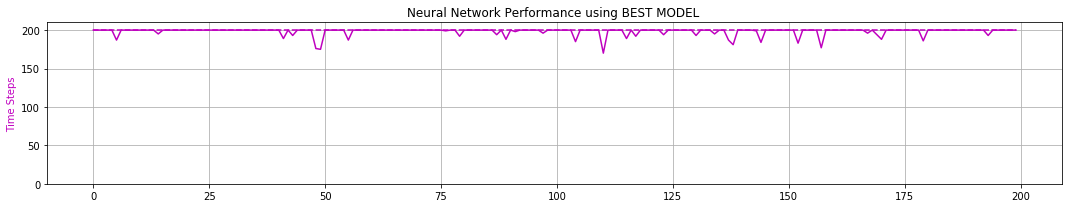

peak memory: 12351.39 MiB, increment: 10758.96 MiB
0 -max- [ 1.715  1.882  0.209  2.057  0.272]
0 -min- [-1.408 -1.858 -0.209 -1.924  0.225]

1 -max- [ 1.531  2.075  0.209  2.263  0.325]
1 -min- [-1.370 -1.914 -0.209 -2.185  0.276]

2 -max- [ 1.369  1.926  0.209  2.282  0.375]
2 -min- [-1.622 -2.409 -0.209 -2.125  0.326]

3 -max- [ 1.569  2.043  0.209  2.163  0.424]
3 -min- [-1.428 -2.094 -0.209 -2.116  0.375]

4 -max- [ 1.510  2.006  0.209  1.921  0.475]
4 -min- [-1.797 -2.257 -0.209 -2.112  0.425]

5 -max- [ 1.369  1.811  0.209  2.137  0.525]
5 -min- [-1.628 -2.242 -0.209 -2.336  0.476]

6 -max- [ 1.700  2.043  0.209  2.515  0.574]
6 -min- [-1.573 -2.200 -0.209 -2.556  0.525]

7 -max- [ 1.475  1.900  0.209  1.931  0.624]
7 -min- [-1.593 -2.211 -0.209 -2.124  0.576]

8 -max- [ 1.700  2.020  0.209  2.270  0.675]
8 -min- [-1.536 -2.040 -0.209 -2.082  0.626]

9 -max- [ 1.729  2.034  0.209  2.186  0.725]
9 -min- [-1.626 -2.275 -0.209 -2.963  0.676]

Quantization TIME:  0.11 minutes


ITER

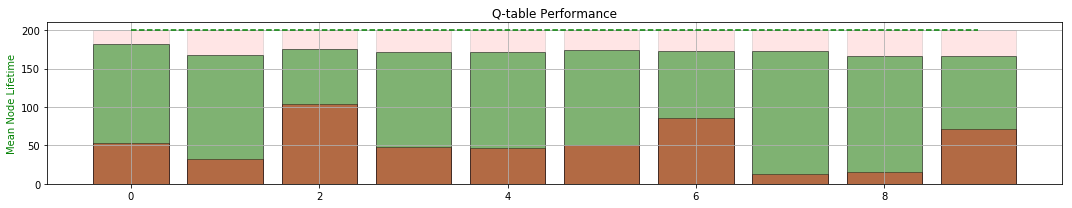

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 67.760	LOSS : 77.635	LOSS : 69.888	LOSS : 57.317	LOSS : 71.102	LOSS : 63.686	LOSS : 67.050	LOSS : 55.942	LOSS : 61.147	LOSS : 64.824	LOSS : 68.170	LOSS : 56.996	LOSS : 67.544	LOSS : 64.176	LOSS : 63.608	LOSS : 58.761	LOSS : 54.275	LOSS : 54.704	LOSS : 59.627	LOSS : 55.861	
Validating... MEAN TIME:  185.735
LOSS : 59.281	LOSS : 56.419	LOSS : 55.220	LOSS : 60.829	LOSS : 59.779	LOSS : 56.840	LOSS : 54.469	LOSS : 55.017	LOSS : 50.119	LOSS : 59.705	LOSS : 50.526	LOSS : 56.035	LOSS : 58.383	LOSS : 56.439	LOSS : 62.770	LOSS : 64.677	LOSS : 54.735	LOSS : 59.604	LOSS : 57.784	LOSS : 64.337	
Validating... MEAN TIME:  166.65
LOSS : 67.061	LOSS : 65.114	LOSS : 58.590	LOSS : 59.240	LOSS : 53.108	LOSS : 60.002	LOSS : 69.564	LOSS : 49.558	LOSS : 57.127	LOSS : 62.972	LOSS : 62.144	LOSS : 70.510	LOSS : 67.087	LOSS : 63.086	LOSS : 51.278	LOSS : 54.674	LOSS : 56.989	LOSS : 59.954	LOSS : 61.748	LOSS : 56.122	
Validat

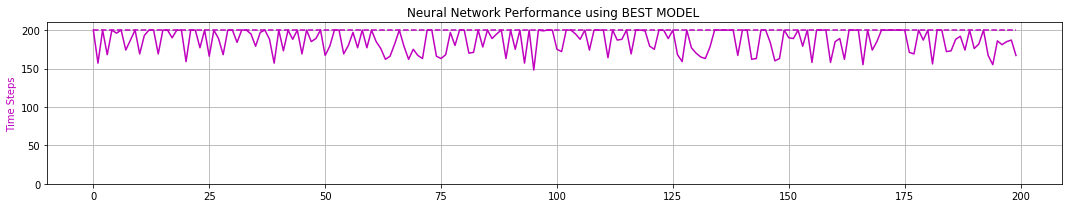

peak memory: 12462.54 MiB, increment: 10815.98 MiB
0 -max- [ 2.187  2.246  0.205  1.803  0.274]
0 -min- [-2.390 -2.580 -0.209 -1.489  0.225]

1 -max- [ 2.136  2.254  0.208  1.619  0.324]
1 -min- [-2.396 -2.607 -0.209 -1.844  0.275]

2 -max- [ 1.171  1.375  0.182  1.563  0.375]
2 -min- [-2.396 -2.612 -0.209 -1.950  0.325]

3 -max- [ 1.340  1.519  0.205  1.838  0.425]
3 -min- [-2.399 -2.510 -0.209 -1.916  0.375]

4 -max- [ 1.358  1.945  0.202  1.607  0.475]
4 -min- [-2.399 -2.614 -0.209 -2.109  0.426]

5 -max- [ 1.593  1.875  0.203  2.073  0.524]
5 -min- [-2.393 -2.590 -0.209 -1.915  0.475]

6 -max- [ 2.397  2.351  0.208  1.867  0.575]
6 -min- [-2.399 -2.611 -0.209 -1.843  0.525]

7 -max- [ 2.357  2.412  0.203  1.732  0.625]
7 -min- [-2.398 -2.636 -0.209 -2.155  0.575]

8 -max- [ 0.482  1.588  0.199  1.754  0.675]
8 -min- [-2.398 -2.774 -0.209 -1.962  0.625]

9 -max- [ 1.460  1.682  0.171  1.842  0.725]
9 -min- [-2.395 -2.606 -0.209 -1.869  0.676]

Quantization TIME:  0.11 minutes


ITER

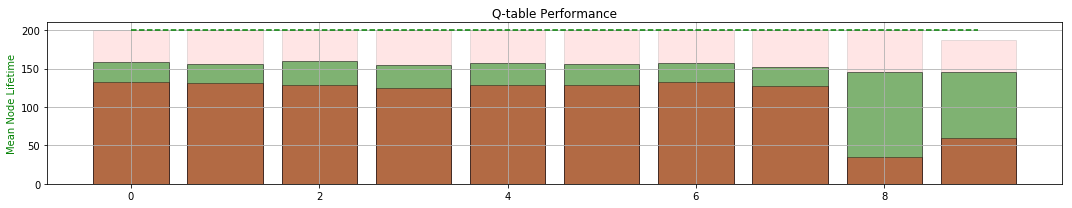

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 70.399	LOSS : 65.662	LOSS : 64.404	LOSS : 62.636	LOSS : 54.165	LOSS : 64.542	LOSS : 61.858	LOSS : 62.288	LOSS : 55.928	LOSS : 55.487	LOSS : 54.506	LOSS : 56.457	LOSS : 59.358	LOSS : 61.846	LOSS : 66.580	LOSS : 58.379	LOSS : 61.171	LOSS : 61.491	LOSS : 48.077	LOSS : 63.541	
Validating... MEAN TIME:  159.765
LOSS : 64.292	LOSS : 58.449	LOSS : 55.554	LOSS : 57.212	LOSS : 57.832	LOSS : 60.667	LOSS : 57.533	LOSS : 54.598	LOSS : 63.575	LOSS : 62.355	LOSS : 57.228	LOSS : 56.466	LOSS : 56.074	LOSS : 50.131	LOSS : 48.183	LOSS : 58.593	LOSS : 57.115	LOSS : 57.051	LOSS : 58.535	LOSS : 55.939	
Validating... MEAN TIME:  159.16
LOSS : 56.159	LOSS : 60.645	LOSS : 55.037	LOSS : 59.568	LOSS : 50.910	LOSS : 55.571	LOSS : 51.308	LOSS : 64.530	LOSS : 58.964	LOSS : 62.605	LOSS : 66.687	LOSS : 55.460	LOSS : 51.231	LOSS : 65.521	LOSS : 46.949	LOSS : 57.601	LOSS : 61.245	LOSS : 51.446	LOSS : 58.457	LOSS : 60.977	
Validat

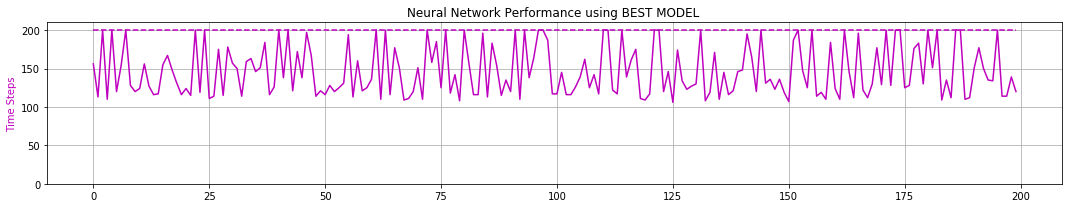

peak memory: 12419.14 MiB, increment: 10752.26 MiB
0 -max- [ 1.052  1.358  0.105  1.461  0.275]
0 -min- [-2.400 -2.704 -0.209 -1.637  0.225]

1 -max- [ 1.034  1.321  0.111  1.629  0.324]
1 -min- [-2.399 -2.750 -0.209 -1.652  0.275]

2 -max- [ 1.341  1.519  0.127  1.601  0.375]
2 -min- [-2.398 -2.738 -0.209 -1.654  0.325]

3 -max- [ 1.135  1.348  0.109  1.649  0.424]
3 -min- [-2.400 -2.730 -0.209 -1.639  0.376]

4 -max- [ 0.667  1.213  0.107  1.647  0.475]
4 -min- [-2.400 -2.704 -0.209 -1.658  0.425]

5 -max- [ 0.116  1.008  0.090  1.850  0.525]
5 -min- [-2.399 -2.730 -0.209 -1.537  0.475]

6 -max- [ 0.625  1.323  0.123  1.927  0.575]
6 -min- [-2.400 -2.733 -0.209 -1.705  0.525]

7 -max- [ 0.136  1.193  0.091  1.663  0.625]
7 -min- [-2.399 -2.775 -0.209 -1.671  0.575]

8 -max- [ 0.150  1.181  0.193  2.147  0.675]
8 -min- [-2.400 -2.763 -0.209 -1.983  0.626]

9 -max- [ 0.161  1.228  0.157  1.934  0.723]
9 -min- [-2.399 -2.770 -0.209 -1.913  0.675]

Quantization TIME:  0.11 minutes


ITER

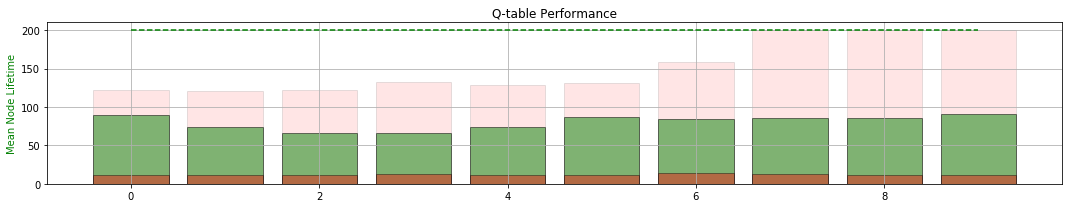

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 87.866	LOSS : 94.830	LOSS : 88.044	LOSS : 74.843	LOSS : 77.814	LOSS : 83.813	LOSS : 84.863	LOSS : 72.839	LOSS : 86.904	LOSS : 78.257	LOSS : 77.639	LOSS : 87.373	LOSS : 88.541	LOSS : 84.684	LOSS : 86.694	LOSS : 90.120	LOSS : 85.734	LOSS : 77.369	LOSS : 74.951	LOSS : 79.938	
Validating... MEAN TIME:  166.38
LOSS : 80.484	LOSS : 82.630	LOSS : 84.350	LOSS : 82.591	LOSS : 88.370	LOSS : 88.964	LOSS : 88.996	LOSS : 83.182	LOSS : 84.412	LOSS : 75.564	LOSS : 79.134	LOSS : 88.151	LOSS : 84.912	LOSS : 87.134	LOSS : 85.476	LOSS : 86.077	LOSS : 75.759	LOSS : 84.641	LOSS : 93.089	LOSS : 81.527	
Validating... MEAN TIME:  162.84
LOSS : 83.666	LOSS : 79.401	LOSS : 89.628	LOSS : 85.244	LOSS : 86.391	LOSS : 78.233	LOSS : 81.688	LOSS : 84.364	LOSS : 84.251	LOSS : 76.652	LOSS : 70.072	LOSS : 72.809	LOSS : 80.158	LOSS : 84.236	LOSS : 91.182	LOSS : 78.667	LOSS : 91.064	LOSS : 78.697	LOSS : 73.187	LOSS : 81.521	
Validati

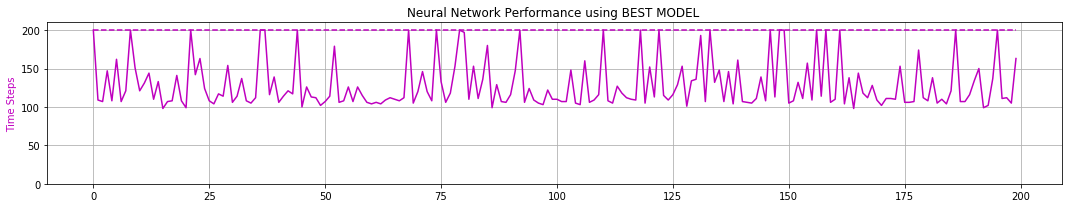

peak memory: 12392.12 MiB, increment: 10741.91 MiB
0 -max- [ 0.195  1.197  0.066  1.636  0.275]
0 -min- [-2.399 -2.930 -0.209 -1.659  0.226]

1 -max- [ 0.191  1.197  0.093  1.774  0.324]
1 -min- [-2.399 -2.935 -0.209 -1.652  0.275]

2 -max- [ 0.219  0.950  0.110  1.886  0.373]
2 -min- [-2.398 -2.932 -0.209 -1.621  0.325]

3 -max- [ 0.202  1.018  0.104  1.818  0.425]
3 -min- [-2.396 -2.926 -0.209 -1.620  0.375]

4 -max- [ 0.207  0.797  0.072  1.767  0.474]
4 -min- [-2.400 -3.080 -0.209 -1.660  0.426]

5 -max- [ 0.179  1.161  0.125  1.632  0.524]
5 -min- [-2.400 -3.170 -0.209 -1.657  0.475]

6 -max- [ 0.135  0.827  0.079  1.608  0.574]
6 -min- [-2.397 -3.169 -0.209 -1.681  0.525]

7 -max- [ 1.305  1.687  0.163  1.569  0.623]
7 -min- [-2.399 -3.152 -0.209 -1.647  0.576]

8 -max- [ 0.345  1.130  0.151  1.638  0.674]
8 -min- [-2.398 -3.138 -0.209 -1.854  0.626]

9 -max- [ 0.549  1.476  0.194  1.777  0.725]
9 -min- [-2.397 -3.147 -0.209 -1.905  0.676]

Quantization TIME:  0.11 minutes


ITER

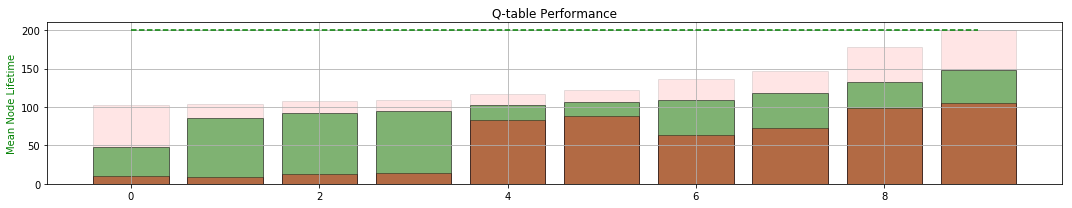

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 105.010	LOSS : 105.399	LOSS : 113.628	LOSS : 100.106	LOSS : 105.675	LOSS : 96.607	LOSS : 95.234	LOSS : 104.227	LOSS : 97.759	LOSS : 91.499	LOSS : 108.260	LOSS : 94.348	LOSS : 94.392	LOSS : 99.596	LOSS : 108.027	LOSS : 108.217	LOSS : 114.361	LOSS : 101.248	LOSS : 91.466	LOSS : 95.444	
Validating... MEAN TIME:  198.595
LOSS : 102.460	LOSS : 100.681	LOSS : 90.330	LOSS : 104.661	LOSS : 98.554	LOSS : 95.984	LOSS : 98.796	LOSS : 83.602	LOSS : 103.558	LOSS : 94.004	LOSS : 103.031	LOSS : 88.228	LOSS : 111.703	LOSS : 88.731	LOSS : 101.049	LOSS : 96.817	LOSS : 95.667	LOSS : 87.161	LOSS : 82.726	LOSS : 91.418	
Validating... MEAN TIME:  200.0
LOSS : 103.796	LOSS : 90.587	LOSS : 93.171	LOSS : 92.412	LOSS : 94.896	LOSS : 83.991	LOSS : 96.686	LOSS : 87.895	LOSS : 102.219	LOSS : 90.032	LOSS : 94.237	LOSS : 94.020	LOSS : 92.936	LOSS : 97.380	LOSS : 101.073	LOSS : 95.113	LOSS : 99.579	LOSS : 97.907	LOSS : 95.704	LO

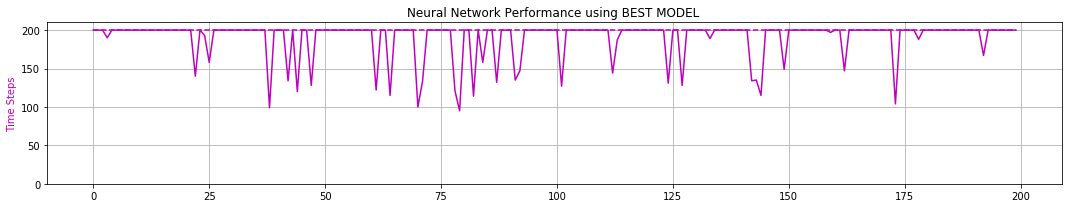

peak memory: 12613.30 MiB, increment: 10935.82 MiB
0 -max- [ 0.193  1.392  0.049  0.946  0.275]
0 -min- [-2.399 -3.120 -0.209 -1.990  0.225]

1 -max- [ 0.208  1.146  0.049  1.132  0.325]
1 -min- [-2.398 -3.166 -0.209 -1.657  0.276]

2 -max- [ 0.184  1.367  0.051  1.045  0.374]
2 -min- [-2.399 -3.169 -0.209 -1.956  0.325]

3 -max- [ 0.174  1.183  0.049  1.309  0.424]
3 -min- [-2.399 -3.320 -0.209 -1.670  0.375]

4 -max- [ 0.158  1.164  0.050  1.312  0.474]
4 -min- [-2.399 -3.164 -0.209 -1.648  0.425]

5 -max- [ 0.144  0.998  0.049  1.261  0.525]
5 -min- [-2.400 -3.181 -0.209 -1.373  0.475]

6 -max- [ 0.144  0.814  0.049  1.107  0.575]
6 -min- [-2.399 -3.346 -0.209 -1.189  0.525]

7 -max- [ 0.096  0.744  0.050  0.953  0.625]
7 -min- [-2.400 -3.168 -0.209 -1.057  0.575]

8 -max- [ 0.087  0.633  0.049  0.907  0.675]
8 -min- [-2.399 -3.164 -0.209 -1.010  0.625]

9 -max- [ 2.394  2.786  0.208  0.966  0.724]
9 -min- [-2.398 -3.166 -0.209 -1.134  0.676]

Quantization TIME:  0.11 minutes


ITER

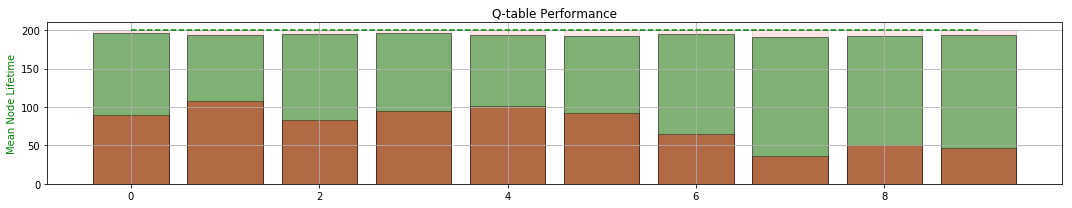

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 94.459	LOSS : 67.513	LOSS : 59.856	LOSS : 64.250	LOSS : 66.698	LOSS : 54.308	LOSS : 60.588	LOSS : 71.867	LOSS : 65.220	LOSS : 60.828	LOSS : 51.975	LOSS : 49.539	LOSS : 60.037	LOSS : 51.546	LOSS : 51.218	LOSS : 58.975	LOSS : 59.704	LOSS : 66.259	LOSS : 61.928	LOSS : 63.133	
Validating... MEAN TIME:  97.445
LOSS : 62.898	LOSS : 56.860	LOSS : 50.350	LOSS : 57.526	LOSS : 62.587	LOSS : 53.470	LOSS : 61.407	LOSS : 56.110	LOSS : 64.257	LOSS : 58.580	LOSS : 58.685	LOSS : 55.400	LOSS : 58.223	LOSS : 59.281	LOSS : 56.991	LOSS : 60.577	LOSS : 52.089	LOSS : 60.634	LOSS : 63.412	LOSS : 53.022	
Validating... MEAN TIME:  137.0
LOSS : 66.645	LOSS : 53.546	LOSS : 56.833	LOSS : 52.621	LOSS : 52.238	LOSS : 51.925	LOSS : 56.054	LOSS : 51.409	LOSS : 58.407	LOSS : 52.360	LOSS : 50.465	LOSS : 48.860	LOSS : 66.657	LOSS : 52.480	LOSS : 46.775	LOSS : 49.129	LOSS : 57.007	LOSS : 55.064	LOSS : 57.770	LOSS : 57.660	
Validatin

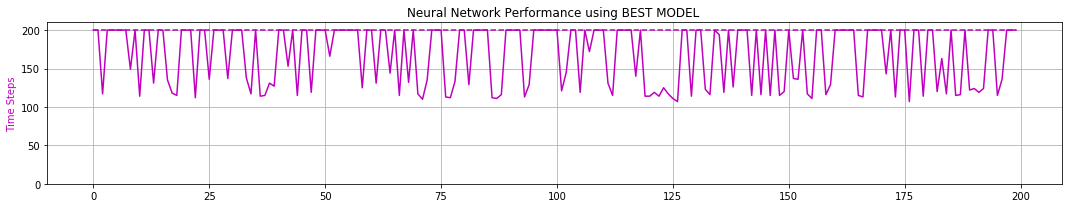

peak memory: 12455.99 MiB, increment: 10741.72 MiB
0 -max- [ 2.067  2.607  0.209  2.212  0.275]
0 -min- [-1.644 -3.129 -0.209 -2.168  0.225]

1 -max- [ 1.711  2.486  0.196  2.145  0.325]
1 -min- [-1.840 -3.143 -0.209 -2.230  0.275]

2 -max- [ 1.548  2.297  0.209  2.075  0.375]
2 -min- [-2.006 -3.452 -0.207 -2.271  0.325]

3 -max- [ 1.389  2.322  0.191  2.140  0.425]
3 -min- [-1.923 -3.437 -0.209 -2.256  0.375]

4 -max- [ 1.232  2.309  0.207  2.125  0.475]
4 -min- [-1.800 -3.086 -0.208 -2.391  0.426]

5 -max- [ 1.127  2.227  0.209  2.197  0.524]
5 -min- [-1.967 -3.116 -0.209 -2.131  0.476]

6 -max- [ 1.089  2.138  0.205  2.096  0.575]
6 -min- [-2.363 -3.521 -0.209 -2.255  0.525]

7 -max- [ 1.219  2.236  0.209  2.147  0.623]
7 -min- [-2.398 -3.475 -0.209 -2.277  0.575]

8 -max- [ 1.115  1.906  0.208  2.217  0.674]
8 -min- [-2.397 -3.441 -0.207 -2.230  0.625]

9 -max- [ 1.204  2.050  0.204  2.113  0.724]
9 -min- [-2.393 -2.551 -0.206 -2.056  0.676]

Quantization TIME:  0.11 minutes


ITER

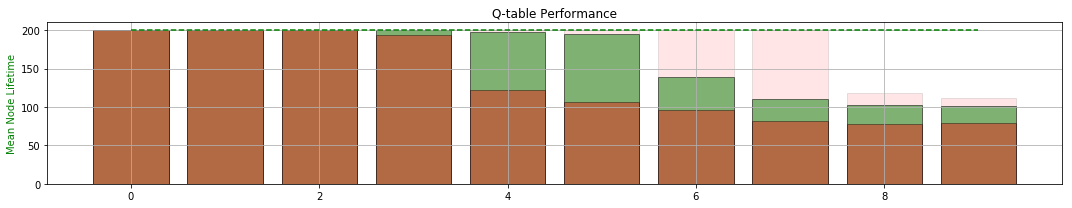

MEMORY COUNTER:  200000
Training Neural Network for 50000 iterations @ LR =  0.001
LOSS : 58.327	LOSS : 57.241	LOSS : 64.774	LOSS : 50.747	LOSS : 55.928	LOSS : 58.345	LOSS : 63.158	LOSS : 52.088	LOSS : 60.320	LOSS : 56.672	LOSS : 55.073	LOSS : 63.569	LOSS : 60.028	LOSS : 59.269	LOSS : 50.078	LOSS : 56.667	LOSS : 62.506	LOSS : 62.219	LOSS : 55.028	LOSS : 53.616	
Validating... MEAN TIME:  200.0
LOSS : 52.757	LOSS : 56.284	LOSS : 54.599	LOSS : 65.399	LOSS : 58.200	LOSS : 47.921	LOSS : 59.406	LOSS : 50.587	LOSS : 63.317	LOSS : 52.669	LOSS : 55.697	LOSS : 56.821	LOSS : 62.000	LOSS : 59.881	LOSS : 56.582	LOSS : 51.204	LOSS : 50.661	LOSS : 52.798	LOSS : 57.355	LOSS : 59.772	
Validating... MEAN TIME:  200.0
LOSS : 61.651	LOSS : 62.573	LOSS : 61.467	LOSS : 75.102	LOSS : 54.510	LOSS : 63.513	LOSS : 61.152	LOSS : 57.643	LOSS : 51.760	LOSS : 52.164	LOSS : 60.761	LOSS : 61.561	LOSS : 60.562	LOSS : 59.384	LOSS : 61.646	LOSS : 61.501	LOSS : 50.906	LOSS : 63.874	LOSS : 59.870	LOSS : 67.540	
Validating

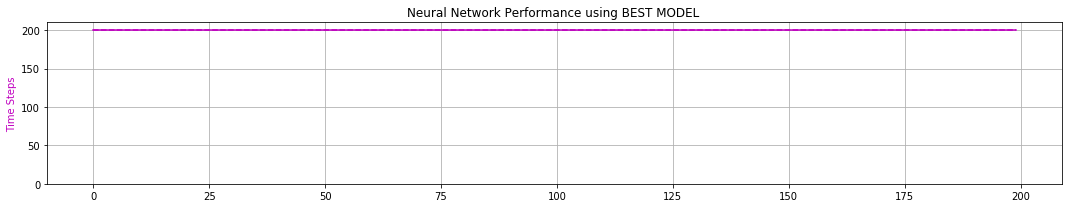

peak memory: 12580.68 MiB, increment: 10935.60 MiB
0 -max- [ 1.525  1.541  0.116  1.183  0.275]
0 -min- [-0.123 -1.165 -0.171 -1.164  0.225]

1 -max- [ 1.173  1.349  0.122  1.173  0.324]
1 -min- [-0.531 -1.966 -0.185 -1.212  0.276]

2 -max- [ 0.758  1.150  0.056  1.097  0.375]
2 -min- [-1.063 -2.593 -0.185 -1.322  0.328]

3 -max- [ 0.589  0.798  0.054  1.160  0.425]
3 -min- [-2.331 -3.251 -0.208 -1.135  0.376]

4 -max- [ 0.241  0.969  0.094  1.091  0.475]
4 -min- [-2.368 -3.256 -0.209 -1.019  0.426]

5 -max- [ 0.107  1.097  0.106  1.059  0.524]
5 -min- [-2.009 -2.509 -0.208 -1.128  0.476]

6 -max- [ 0.113  0.931  0.093  0.880  0.575]
6 -min- [-2.398 -3.304 -0.209 -1.173  0.525]

7 -max- [ 0.159  1.023  0.079  0.793  0.625]
7 -min- [-2.400 -3.322 -0.209 -1.435  0.576]

8 -max- [ 0.147  1.017  0.050  0.810  0.675]
8 -min- [-2.399 -3.255 -0.209 -1.454  0.626]

9 -max- [ 0.174  1.188  0.049  0.850  0.725]
9 -min- [-2.400 -3.352 -0.209 -1.678  0.676]

Quantization TIME:  0.13 minutes


ITER

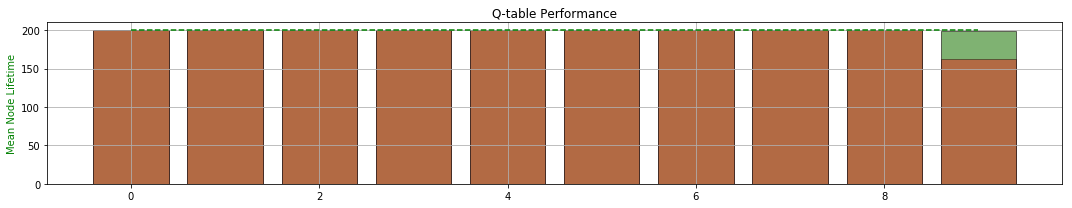

In [20]:
while iteration < MAX_NO_OF_ITERATIONS:

    print("\n")
    print("ITERATION #", iteration)
    tic = datetime.now()
    
    # MAP GYM ENVIRONMENT TO EACH PROCESS IN THE POOL
    ##################################################################
    q_table_list = [node_q_table]* NO_OF_NODES
    iter_list = [iteration] * NO_OF_NODES
    arg_list = [arg for arg in zip(range(NO_OF_NODES), node_boundaries, iter_list, q_table_list)]
    result   = pool.starmap(mp_node_run, arg_list)
    ##################################################################
    
    # GATHER RESULTS
    ##################################################################
    node_boundaries = np.array([item[2] for item in result])
    node_time_rec   = np.array([item[1] for item in result])
    node_exp        = np.array([item[0] for item in result])
    
    all_exp         = np.array([item for each_node_exp in node_exp 
                                    for episode_exp in each_node_exp 
                                    for item in episode_exp]).reshape(-1,N_STATES*2+2)
    total_parallel_timesteps += node_time_rec.max()
    total_serial_timesteps   += node_time_rec.sum()
    EXP_GEN = node_time_rec.sum().astype(int)
    
    print("TOTAL EXPERIENCE GENERATED:   {:d}".format(EXP_GEN.astype(int)))

    print("SMALLEST TIMESTEP: {:d}".format(node_time_rec.min().astype(int)))
    print("LARGEST  TIMESTEP: {:d}".format(node_time_rec.max().astype(int)))

    print("TOTAL SERIAL TIMESTEPS:   {:d}".format(total_serial_timesteps.astype(int)))
    print("TOTAL PARALLEL TIMESTEPS: {:d}".format(total_parallel_timesteps.astype(int)))
    ##################################################################

    # PLOT EXPERIENCES
    ##################################################################
    node_avg_time = node_time_rec.mean(axis=1)
    node_std_time = node_time_rec.std(axis=1)
    node_max_time = node_time_rec.max(axis=1)
    node_min_time = node_time_rec.min(axis=1)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    ax2.set_title("Q-table Performance")
    ax2.bar(range(NO_OF_NODES) , node_max_time, alpha = 0.1, color = 'r', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_avg_time, alpha = 0.5, color = 'g', edgecolor = 'black', capsize=7 )
    ax2.bar(range(NO_OF_NODES) , node_min_time, alpha = 0.4, color = 'r', edgecolor = 'black', capsize=7 )

    ax2.plot(np.ones_like(node_avg_time)*200, 'g--')
    ax2.set_ylabel('Mean Node Lifetime',color = 'g')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    ##################################################################
    
    if node_avg_time[node_avg_time >= 195].shape[0] > NO_OF_NODES/2:
        final_result = "SUCCESS"
        break

    # SEGREGATE AND STORE EXPERIENCES
    ##################################################################
    dqn.memory = np.insert(dqn.memory,0,all_exp,0)
    dqn.memory = dqn.memory[:MIN_MEMORY_CAP,:]
    dqn.memory_counter += all_exp.shape[0]
#     good_mem = all_exp[all_exp[:,N_STATES+1] == 1]    
#     bad_mem  = all_exp[all_exp[:,N_STATES+1] < 1]


#     dqn.good_memory = np.insert(dqn.good_memory, 0, good_mem , 0)
#     dqn.good_memory_counter += good_mem.shape[0]

#     dqn.bad_memory  = np.insert(dqn.bad_memory, 0, bad_mem , 0)
#     dqn.bad_memory_counter += bad_mem.shape[0]

#     dqn.good_memory = dqn.good_memory[:MIN_MEMORY_CAP,:]
#     dqn.bad_memory = dqn.bad_memory[:MIN_MEMORY_CAP,:]

    NN_ITERATIONS = MAX_NN_ITERATIONS
    print("MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.memory_counter))

#     print("GOOD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.good_memory_counter))
#     print("BAD MEMORY COUNTER: ", min(MIN_MEMORY_CAP, dqn.bad_memory_counter))
    ##################################################################

    # LEARN
    ##################################################################
    print("Training Neural Network for", NN_ITERATIONS, "iterations", "@ LR = ", NN_LR)
    tic=datetime.now()
    nn_level_up_metric = 0
    for nn_iter in range(NN_ITERATIONS):
        dqn.learn()
        #validate by running for TIMESTEP_LIMIT iterations
        if(nn_iter%int(NN_ITERATIONS/5) == int(NN_ITERATIONS/5)-1):
            print("\nValidating... ",end="")
            time_rec = []
            v_env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
            v_xtra = [v_env.length]
            for i_episode in range(TIMESTEP_LIMIT):
                time_step = 0
                s = v_env.reset()
                s = np.append(s, v_xtra)
                while True:
                    time_step += 1 
                    a = dqn.choose_greedy_action(s)
                    s_, r, done, info = v_env.step(a)
                    s_ = np.append(s_, v_xtra)
                    if done:
                        break
                    s = s_
                time_rec = np.append(time_rec, time_step)
            mean_time = time_rec.mean()
            print("MEAN TIME: ", mean_time)
            if mean_time >= nn_level_up_metric:
                nn_level_up_metric = mean_time
                nn_level_up_metric = clamp(0, nn_level_up_metric, 195)
                torch.save(dqn.eval_net.state_dict(), MODEL_FILENAME)

    print("TRAINING TIME:{}".format(datetime.now()-tic))
    ##################################################################

    # CHECK PERFORMANCE OF THE BEST MODEL
    ##################################################################
    best_dqn = D3QN()
    best_dqn.eval_net.load_state_dict(torch.load(MODEL_FILENAME))
    best_dqn.eval_net.eval()

    time_rec = []
    for i_episode in range(TIMESTEP_LIMIT):
        env.length   = np.random.uniform(LENGTH_ABS_MIN, LENGTH_ABS_MAX)
        Xtra = [env.length]
        time_step = 0
        s = env.reset()
        s = np.append(s, Xtra)

        while True:
    #         env.render()
            time_step += 1 
            a = best_dqn.choose_greedy_action(s)
            s_, r, done, info = env.step(a)
            s_ = np.append(s_, Xtra)

            if done:
                break
            s = s_
        time_rec = np.append(time_rec, time_step)

    fig = plt.figure(figsize = (15,3))
    ax2 = fig.add_subplot(1, 1, 1)
    data = time_rec
    ax2.plot(data, color = 'm')
    ax2.plot(np.ones_like(data)*200, 'm--')
    ax2.set_title('Neural Network Performance using BEST MODEL ')
    ax2.set_ylabel('Time Steps',color = 'm')
    ax2.set_ylim(0,TIMESTEP_LIMIT+10)
    fig.tight_layout()
    ax2.grid()
    plt.show()
    
    
        
    ##################################################################
    
    # CREATE ONE LARGE Q-TABLES FROM WHICH THE NODES STRIP
    ##################################################################
        
#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN * NO_OF_NODES  ])
    
    start = timeit.default_timer()
    # GET Q-VALUES 
    %memit node_q_table = best_dqn.get_greedy_action(init_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN, LO_GRAIN*NO_OF_NODES).astype(np.intp)

    # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
    stop = timeit.default_timer()

#     ##################################################################
    
#     # CREATE INDIVIDUALIZED Q-TABLES FOR THE NODES
#     ##################################################################
    
    for node_id in range(NO_OF_NODES):
# #         # SET STATE VALUE BORDERS AS REQUESTED BY THE NODE
# #         ###############################################
#         [C_POS_MAX, C_VEL_MAX, P_ANG_MAX, P_VEL_MAX, LENGTH_MAX,
#          C_POS_MIN, C_VEL_MIN, P_ANG_MIN, P_VEL_MIN, LENGTH_MIN]  = node_boundaries[node_id]
# #         ###############################################
        print(node_id,'-max-',node_boundaries[node_id][:N_STATES])
        print(node_id,'-min-',node_boundaries[node_id][N_STATES:])
        print("")
        
# #         node_boundaries[node_id] = [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_MAX,
# #                                     C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_MIN]
# #         # CREATE STATE COMBINATIONS
# #         ###############################################

#     node_state_combinations = ndim_grid([C_POS_ABS_MIN, C_VEL_ABS_MIN, P_ANG_ABS_MIN, P_VEL_ABS_MIN, LENGTH_ABS_MIN ],
#                                         [C_POS_ABS_MAX, C_VEL_ABS_MAX, P_ANG_ABS_MAX, P_VEL_ABS_MAX, LENGTH_ABS_MAX ],
#                                         [HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN   ])
#         ###############################################
#     start = timeit.default_timer()
#     # GET Q-VALUES 
#     %memit node_q_table = best_dqn.get_qvals(node_state_combinations).reshape(HI_GRAIN , HI_GRAIN , HI_GRAIN , HI_GRAIN , LO_GRAIN , -1).astype(np.float16)

#     # SAVE QFILE
#     np.save(node_QFILE, node_q_table)
#         #############################################################################################################################################
#     stop = timeit.default_timer()
    print("Quantization TIME: ", np.round((stop-start)/60,2), "minutes")
    iteration += 1
pool.close()
pool.join()

In [21]:
print("Total Parallel Timesteps : ", total_parallel_timesteps)
print("Total Serial Timesteps   : ", total_serial_timesteps)
print("Speed-up                 :  {:6.2f}".format(total_serial_timesteps/total_parallel_timesteps))

Total Parallel Timesteps :  1686.0
Total Serial Timesteps   :  1218613.0
Speed-up                 :  722.78


In [22]:
pool.close()
pool.join()
if iteration == MAX_NO_OF_ITERATIONS:
    final_result = "FAILURE"

In [23]:
print("{:6d} {} {:3d} {:3d} {:7d} {:10d} {:10.2f}".format(seed, final_result, int(node_min_time.min()), int(iteration), int(total_parallel_timesteps), int(total_serial_timesteps), total_serial_timesteps/total_parallel_timesteps))

   741 SUCCESS 163   8    1686    1218613     722.78
